In [1]:
# Import libraries
import glob
import numpy as np
import pandas as pd
import tensorflow as tf
from random import gauss
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import pairwise_distances

np.random.seed(0)

# 1. Read Data

In [2]:
data = pd.read_pickle('air_quality/data.pkl')

In [3]:
# Create X and Y
w = 6 

X, y = [], []
for i in range(w, data.shape[0]): # indices to loop over   
    X.append(data[i-w:i]) # past data 
    y.append(data[i][:, 0]) # current data across all cities, 1st feature(PM2.5)
    
X, y = np.array(X), np.array(y)
print(X.shape, y.shape)

(35058, 6, 12, 27) (35058, 12)


In [4]:
n_samples, tau, n_cities, n_features = X.shape

In [5]:
tr_pct = 0.7
split_idx = int(X.shape[0]*tr_pct)
X_tr, y_tr = X[:split_idx], y[:split_idx]
X_te, y_te = X[split_idx:], y[split_idx:]

print(X_tr.shape, y_tr.shape, X_te.shape, y_te.shape)

(24540, 6, 12, 27) (24540, 12) (10518, 6, 12, 27) (10518, 12)


# 2. Graphs

## 2.1. Time Graph

In [6]:
# Adjacency matrix as a constant variable (N x N)
lbw = 6
damping_constant = 0.9
A_t = np.zeros((lbw, lbw))
for row_idx in range(A_t.shape[0]):
    for col_idx in range(A_t.shape[1]):
        if col_idx > row_idx:
            A_t[row_idx, col_idx] = damping_constant**(col_idx-row_idx)

A_t = A_t.T
A_t = pd.DataFrame(A_t)

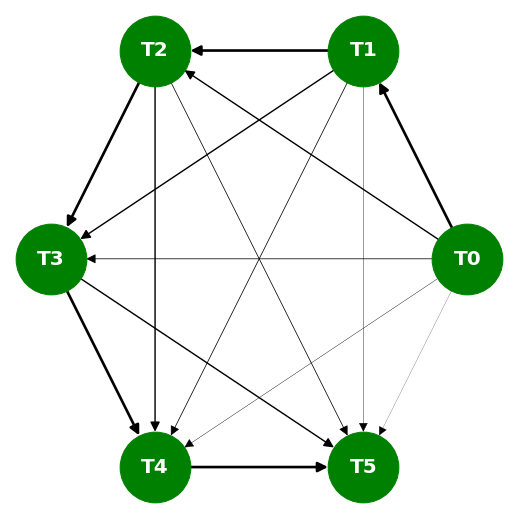

In [7]:
# PLOTTING FUNCITONS
import networkx as nx

cols = [f'T{c}' for c in A_t.columns]
A_t.columns, A_t.index = cols, cols

G = nx.from_pandas_adjacency(A_t.T, create_using=nx.DiGraph)
edges = G.edges()
weights = [G[u][v]['weight']**6 *5 for u,v in edges]

plt.figure(figsize=(7, 7))
nx.draw_circular(G, edges=edges, with_labels=True, 
                 node_size=5000, node_color='GREEN', 
                 font_color='white', font_weight=1000, font_size=20,
                 width=weights, arrowsize=20)
                 #edge_color=weights, edge_cmap=plt.get_cmap("cool"), width=3)

plt.savefig('A_t.png', dpi=300)

## 2.2. Location Graph

In [8]:
A_s = np.corrcoef(X_tr.transpose(2, 0, 1, 3).reshape(12, -1))**2
A_s[range(A_s.shape[0]), range(A_s.shape[0])] = 0 
A_s[A_s < 0.6] = 0

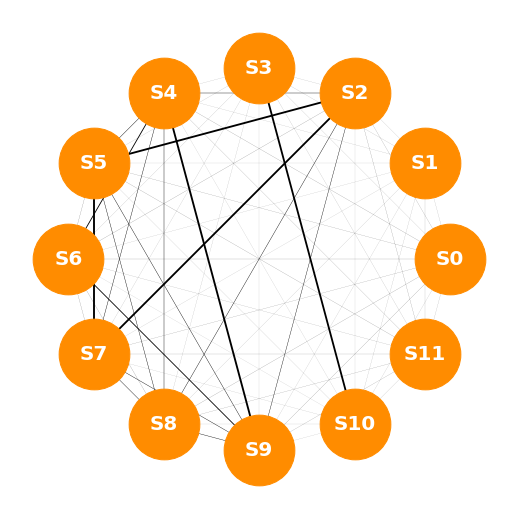

In [9]:
# PLOTTING FUNCITONS
import networkx as nx

A_s = np.corrcoef(X_tr.transpose(2, 0, 1, 3).reshape(12, -1))**2
A_s[range(A_s.shape[0]), range(A_s.shape[0])] = 0 

A_s = pd.DataFrame(A_s, index=range(12), columns=range(12))
cols = [f'S{c}' for c in A_s.columns]
A_s.columns, A_s.index = cols, cols

G = nx.from_pandas_adjacency(A_s, create_using=nx.Graph)
edges = G.edges()
weights = [G[u][v]['weight']**1.5 *2 for u,v in edges]

plt.figure(figsize=(7, 7))
nx.draw_circular(G, edges=edges, with_labels=True, 
                 node_size=5000, node_color='DARKORANGE', 
                 font_color='white', font_weight=1000, font_size=20,
                 width=weights, arrowsize=30)
                 #edge_color=weights, edge_cmap=plt.get_cmap("cool"), width=3)

# Avoid getting cutoff
axis = plt.gca()
axis.set_xlim([1.2*x for x in axis.get_xlim()])
axis.set_ylim([1.2*y for y in axis.get_ylim()])

plt.savefig('A_s.png', dpi=300)

# 3. Modelling

## 3.1. MGTN

In [10]:
import tensorflow as tf
from GraphTensorNetworks import SpecialMultiGraphTensorNetwork as SMGTN
from GraphTensorNetworks import TensorTrainLayer as TTL

tf.random.set_seed(0)

In [11]:
graph_list = [A_t.values, A_s]
tt_ips = [X.shape[1], X.shape[2], 8]
tt_ops = [2,2,2]
tt_ranks = [1,2,2,1]

In [12]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Input(shape=X.shape[1:]))

model.add(SMGTN(tt_ips[-1], graph_list, bias_bool=False))
model.add(tf.keras.layers.Activation('tanh'))

model.add(TTL(tt_ips, tt_ops, tt_ranks))
model.add(tf.keras.layers.Activation('tanh'))
model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(y.shape[1]))

model.compile(loss='mse', optimizer=tf.keras.optimizers.RMSprop(lr=0.002))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
special_multi_graph_tensor_n (None, 6, 12, 8)          218       
_________________________________________________________________
activation (Activation)      (None, 6, 12, 8)          0         
_________________________________________________________________
tensor_train_layer (TensorTr (None, 2, 2, 2)           160       
_________________________________________________________________
activation_1 (Activation)    (None, 2, 2, 2)           0         
_________________________________________________________________
flatten (Flatten)            (None, 8)                 0         
_________________________________________________________________
dense (Dense)                (None, 12)                108       
Total params: 486
Trainable params: 486
Non-trainable params: 0
__________________________________________________________

In [13]:
model.fit(X_tr, y_tr, validation_split=0.2, epochs=50, shuffle=False, verbose=False)

In [14]:
from sklearn.metrics import mean_squared_error

In [15]:
preds = model.predict(X_tr)
mean_squared_error(preds.reshape(-1), y_tr.reshape(-1))

0.0917080171893418

In [16]:
preds = model.predict(X_te)
mean_squared_error(preds.reshape(-1), y_te.reshape(-1))

0.13212186488622804

## 3.2. TTNN Model

In [17]:
X_tr.shape

(24540, 6, 12, 27)

In [18]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Input(shape=X.shape[1:]))

model.add(TTL([6, 12, 27], [2, 2, 2], tt_ranks))
model.add(tf.keras.layers.Activation('tanh'))

model.add(TTL([2, 2, 2], tt_ops, tt_ranks))
model.add(tf.keras.layers.Activation('tanh'))
model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(y.shape[1]))

model.compile(loss='mse', optimizer=tf.keras.optimizers.RMSprop(lr=0.002))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
tensor_train_layer_1 (Tensor (None, 2, 2, 2)           236       
_________________________________________________________________
activation_2 (Activation)    (None, 2, 2, 2)           0         
_________________________________________________________________
tensor_train_layer_2 (Tensor (None, 2, 2, 2)           40        
_________________________________________________________________
activation_3 (Activation)    (None, 2, 2, 2)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 12)                108       
Total params: 384
Trainable params: 384
Non-trainable params: 0
________________________________________________________

In [19]:
model.fit(X_tr, y_tr, validation_split=0.2, epochs=50, shuffle=False, verbose=False)

In [20]:
preds = model.predict(X_tr)
mean_squared_error(preds.reshape(-1), y_tr.reshape(-1))

0.10218852929457538

In [21]:
preds = model.predict(X_te)
mean_squared_error(preds.reshape(-1), y_te.reshape(-1))

0.13298125626724072

## 3.3. GRU Model

In [22]:
X_tr_gru = X_tr.reshape(X_tr.shape[0], lbw, -1)
X_te_gru = X_te.reshape(X_te.shape[0], lbw, -1)

In [23]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Input(shape=X_tr_gru.shape[1:]))

model.add(tf.keras.layers.GRU(8, return_sequences=True))
model.add(tf.keras.layers.Activation('tanh'))
model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(2**3))
model.add(tf.keras.layers.Activation('tanh'))

model.add(tf.keras.layers.Dense(y.shape[1]))

model.compile(loss='mse', optimizer=tf.keras.optimizers.RMSprop(lr=0.002))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 6, 8)              8016      
_________________________________________________________________
activation_4 (Activation)    (None, 6, 8)              0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 48)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 392       
_________________________________________________________________
activation_5 (Activation)    (None, 8)                 0         
_________________________________________________________________
dense_3 (Dense)              (None, 12)                108       
Total params: 8,516
Trainable params: 8,516
Non-trainable params: 0
____________________________________________________

In [24]:
model.fit(X_tr_gru, y_tr, validation_split=0.2, epochs=50, shuffle=False, verbose=False)

In [25]:
preds = model.predict(X_tr_gru)
mean_squared_error(preds.reshape(-1), y_tr.reshape(-1))

0.11017354402954334

In [26]:
preds = model.predict(X_te_gru)
mean_squared_error(preds.reshape(-1), y_te.reshape(-1))

0.16804346740211995

## 3.4. GCN Model

In [27]:
X_tr_gcn = X_tr.transpose(0, 2, 1, 3).reshape(X_tr.shape[0], A_s.shape[0], -1)
X_te_gcn = X_te.transpose(0, 2, 1, 3).reshape(X_te.shape[0], A_s.shape[0], -1)

In [28]:
from GraphTensorNetworks import GraphCNN

In [29]:
g_filter = tf.keras.backend.constant(A_s + np.eye(A_s.shape[0]))

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Input(shape=(A_s.shape[0], X_tr_gcn.shape[-1])))

model.add(GraphCNN(output_dim=8, num_filters=1, graph_conv_filters=g_filter, input_shape=X_tr_gcn.shape[1:]))
model.add(tf.keras.layers.Activation('tanh'))
model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(2**3))
model.add(tf.keras.layers.Activation('tanh'))

model.add(tf.keras.layers.Dense(y.shape[1]))

model.compile(loss='mse', optimizer=tf.keras.optimizers.RMSprop(lr=0.002))

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
graph_cnn (GraphCNN)         (None, 12, 8)             1296      
_________________________________________________________________
activation_6 (Activation)    (None, 12, 8)             0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 96)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 776       
_________________________________________________________________
activation_7 (Activation)    (None, 8)                 0         
_________________________________________________________________
dense_5 (Dense)              (None, 12)                108       
Total params: 2,180
Trainable params: 2,180
Non-trainable params: 0
____________________________________________________

In [30]:
model.fit(X_tr_gcn, y_tr, validation_split=0.2, epochs=50, shuffle=False, verbose=False)

In [31]:
preds = model.predict(X_tr_gcn)
mean_squared_error(preds.reshape(-1), y_tr.reshape(-1))

0.223925072778321

In [32]:
preds = model.predict(X_te_gcn)
mean_squared_error(preds.reshape(-1), y_te.reshape(-1))

0.336235934147879